# Sujet 1 : Concentration de CO2 dans l'atmosphère depuis 1958

 Charles David Keeling a lancé une campagne de mesure de la concentration de C02 dans l'atmosphère. Il a installé ces instrument à l'observatoire de Mauna Loa, Hawaii, Etats-Unis. Depuis 1958, nous avons continuellement des données.
 
 L'étude initiale devait étudier les variations saisonnière de la concentration, mais avec le réchauffement climatique, elle se tourne maintenant sur la croissance de la concentration.
 
 A partir des données hebdomadaires disponible sur le [site Web de l'institut Scripps](https://www.scripps.edu/), nous souhaitons reproduire l'analyse de l'évolution de la concentration de C02 dans l'atmosphère pour faire un modèle prédictif.

## Chargement et inspection des données

In [1]:
 %matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import urllib

 Dans le cas où le jeu de donnée n est pas disponible en local, nous téléchargeons le jeu de données complets hebdomadaire du 6 Avril 2020 depuis le lien suivant : https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv

In [2]:
data_url = "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv"
data_filename = "weekly_in_situ_co2_mlo.csv"
# Si les données ne sont pas disponibles localement
if not(os.path.exists(data_filename)):
    # Alors les télécharger depuis le site officiel
    urllib.request.urlretrieve(data_url,data_filename)
# Vérifier que le fichier n'est pas vide
assert os.path.getsize(data_filename)>0

Il ne semble pas y avoir de souci lors de l'ouverture du fichier pour une vérification visuelle. En revanche, ce fichier CSV possède un en-tête conséquent qu'il va falloir "enlever" lors de la récupération des données. Pour cela, nous allons chercher automatiquemlent la première ligne de données (pour pallier tout changement de format du fichier par l'institut Scripps.

In [3]:
def find_num_first_dataline(filename):
    with open(filename,"r") as f:
        lignes = f.readlines()
    for i,ligne in enumerate(lignes):
        if ligne[0] != '"':
            return i
    raise Exception("No data")

# Call the function
first_line = find_num_first_dataline(data_filename)

Après l'observsation du fichier et de l'en-tête, on peut se rendre compte que:
* La première colonne correspond aux dates d'acquisition (12h chaque jour)
* La seconde colonne correspond aux concentrations mesurées (moyenne par jour)

In [4]:
data = pd.read_csv(data_filename,skiprows=first_line,header=None,names=["Date","Concentration"])
data

Date  Concentration
0     1958-03-29         316.19
1     1958-04-05         317.31
2     1958-04-12         317.69
3     1958-04-19         317.58
4     1958-04-26         316.48
5     1958-05-03         316.95
6     1958-05-17         317.56
7     1958-05-24         317.99
8     1958-07-05         315.85
9     1958-07-12         315.85
10    1958-07-19         315.46
11    1958-07-26         315.59
12    1958-08-02         315.64
13    1958-08-09         315.10
14    1958-08-16         315.09
15    1958-08-30         314.14
16    1958-09-06         313.54
17    1958-11-08         313.05
18    1958-11-15         313.26
19    1958-11-22         313.57
20    1958-11-29         314.01
21    1958-12-06         314.56
22    1958-12-13         314.41
23    1958-12-20         314.77
24    1958-12-27         315.21
25    1959-01-03         315.24
26    1959-01-10         315.50
27    1959-01-17         315.69
28    1959-01-24         315.86
29    1959-01-31         315.42
...          ...            ...
3126  2019-07-06         412.69
3127  2019-07-13         412.30
3128  2019-07-20         411.76
3129  2019-07-27         410.32
3130  2019-08-03         410.50
3131  2019-08-10         410.48
3132  2019-08-17         410.05
3133  2019-08-24         409.52
3134  2019-08-31         409.32
3135  2019-09-07         408.80
3136  2019-09-14         408.61
3137  2019-09-21         408.50
3138  2019-09-28         408.28
3139  2019-10-05         407.99
3140  2019-10-12         408.61
3141  2019-10-19         408.77
3142  2019-10-26         408.68
3143  2019-11-02         409.86
3144  2019-11-09         410.15
3145  2019-11-16         410.22
3146  2019-11-23         410.48
3147  2019-11-30         410.92
3148  2019-12-07         411.27
3149  2019-12-14         411.67
3150  2019-12-21         412.30
3151  2019-12-28         412.59
3152  2020-01-04         413.19
3153  2020-01-11         413.39
3154  2020-01-25         413.36
3155  2020-02-01         413.99

[3156 rows x 2 columns]

Conversion des date en un format utilisable pour les librairies

In [5]:
def convert_date(year_month_day_int):
    year_month_day_str = str(year_month_day_int)
    return pd.Timestamp(year=int(year_month_day_str[:4]),month=int(year_month_day_str[5:7]),day=int(year_month_day_str[8:]),hour=12)

data["Datetime"] = [convert_date(ymd) for ymd in data["Date"]]
data["Timestamp"] = [date.value/10**8 for date in data["Datetime"]]
data["Period"] = [date.to_period('W') for date in data["Datetime"]]
data.set_index("Period");

Génération et affichage du graphique

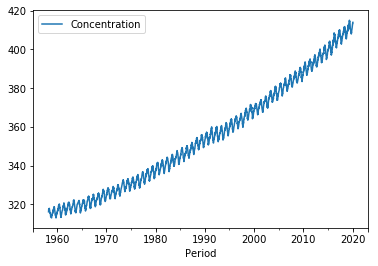

In [6]:
data.plot(x="Period",y="Concentration")
plt.show()

## Décomposition
Bien que la courbe soit croissante, on peut apercevoir un motif répétitif qu'il serait intéressant d'étudier

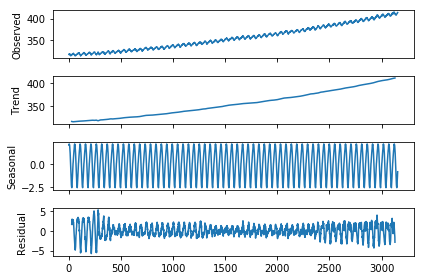

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['Concentration'],model="additive", freq=52) # 52 weeks a year
result.plot()
plt.show()

Si les bruits semblent assez irréguliers, ce n'est pas le cas de la tendance globale et des saisons. La saison semble régulière dans ses oscillations mais la tendance globale est en constante hausse.

## Prédictions
D'après la décomposition précédente, il semble que la fonction de prédiction peut être estimée comme la somme d'une fonction affine croissante (Trend) et d'une fonction périodique (Seasonal).

In [8]:
data["Step"]=1
linmodel = sm.GLM(data['Concentration'],data[['Step','Timestamp']]).fit()

def predict(year=2025,month=6,day=1,hour=12):
    datetime = pd.Timestamp(year=year,month=month,day=day,hour=hour)
    date_pred = pd.DataFrame({'Timestamp':[datetime.value],'Intercept':1},index=[datetime])
    return linmodel.predict(date_pred)

predict()

2025-06-01 12:00:00    8.744577e+09
dtype: float64